# Import, options

In [11]:
import numpy, seaborn, pandas, gseapy
import scipy.stats as stats
import matplotlib, matplotlib.pyplot as plt
import statsmodels.api

from gseapy import barplot, dotplot
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import fcluster
from scipy.stats import linregress

In [12]:
matplotlib.rcParams.update({'svg.fonttype' : 'none'})
#'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20,'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',                            'figure.figsize':(8, 5), 

In [13]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# Data Download

In [14]:
# Values are Protein abundance by TMT reporter ion intensity
# Stats are ANOVA
# Peptides number = 15487

In [15]:
#data Proteomics
df = pandas.read_csv(file_directory+'1) input/proteomics/Pilot_ProteomicsData.csv', 
                     sep = ',', index_col = 'Gene')
df = df.iloc[:,4:-3]

df.columns = df.columns.str.split('_').str[0]
df_with_tripl = df.copy()
df = df.groupby(axis=1, level=0).median()
df = df[['Ctrl', '3h', '6h', '9h', '12h', '16h']]

print(df.shape, '\n')
df.head(3)

(2405, 6) 



C:\Users\kja11\AppData\Local\Temp\ipykernel_19784\3986874491.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(axis=1, level=0).median()


,Ctrl,3h,6h,9h,12h,16h
Gene,,,,,,
DIS3,92.9,96.6,91.6,105.8,103.0,115.5
LARP1,103.3,106.6,103.5,99.1,95.3,93.2
ACTB,100.9,107.1,102.3,94.4,93.9,100.4


In [20]:
# List of filtered proteins
proteomics_path = file_directory + "3) output/Proteomics/"

with open(proteomics_path+'Late_res_CoeffVar_proteins.txt') as f:
    late_res_CoeffVar_proteins = f.read().splitlines()
    
print("late_res_CoeffVar_proteins:", len(late_res_CoeffVar_proteins))

late_res_CoeffVar_proteins: 408


# Data transformation

## To Zscore 

In [17]:
# Convert to Z_score
df_zscore = stats.zscore(df, axis = 0)
df_zscore.head(2)

,Ctrl,3h,6h,9h,12h,16h
Gene,,,,,,
DIS3,-1.092419,-0.367305,-1.569021,0.917407,0.601398,2.127101
LARP1,0.748607,1.131631,0.843713,-0.246745,-0.859439,-1.056857


In [21]:
df_lateR = df_zscore[df_zscore.index.isin(late_res_CoeffVar_proteins)]
len(df_lateR)

408

# Methods

### Clusterization

number of proteins: 408


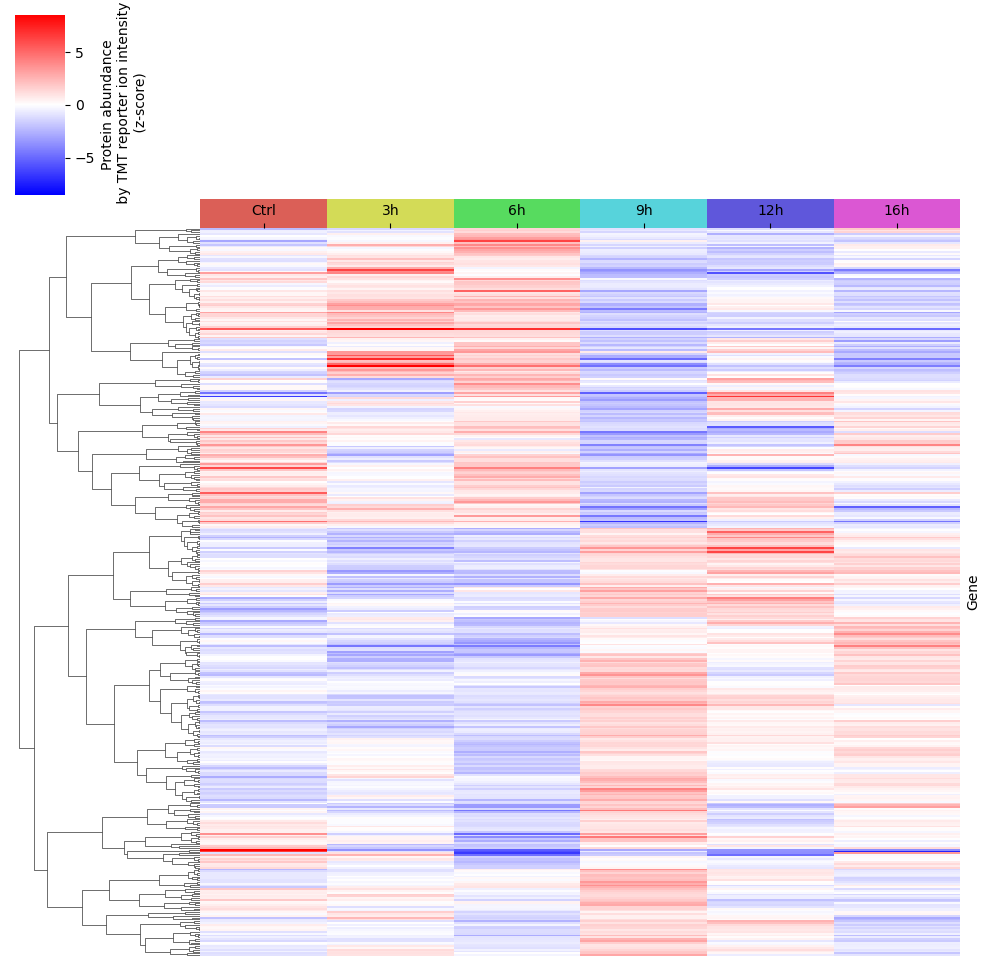

In [22]:
# Heatmap of proteins with high variation 3h from CTL
## define the colors, one color per condition 
lut = dict(zip(df_lateR.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_lateR.columns.map(lut)

## plot heatmap
print('number of proteins:', len(df_lateR))
g =  seaborn.clustermap(df_lateR, 
                        cmap='bwr', 
                        row_cluster=True, 
                        col_cluster=False, 
                        vmin=-8.5, vmax=8.5,
                        col_colors = col_colors_conditions,
                        cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                        xticklabels=True, yticklabels=False, 
                        method='complete', metric='cosine')

g.ax_heatmap.xaxis.set_ticks_position('top')
g.ax_heatmap.xaxis.set_label_position('top')


### Select the proteins with positive / negative late answer

In [ ]:
reordered_indices = heatmapname.dendrogram_row.reordered_ind #the index in the heatmap
linkage_matrix  = heatmapname.dendrogram_row.linkage #the matrix for heatmap
num_clusters = 2 # cluster expected

#Get the cluster labels for each sample
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
print(cluster_labels[:10])

groupDown_samples = [sample_names[i] for i in range(len(sample_names)) if cluster_labels[i] == 1]
groupUp_samples = [sample_names[i] for i in range(len(sample_names)) if cluster_labels[i] == 2]
print(groupUp_samples[:10])

print(f'\nn = {len(groupDown_samples)} down regulated in late response\nn= {len(groupUp_samples)} up regulated in late response')

In [23]:
sample_names = df_lateR.index
num_samples = len(sample_names)

reordered_indices = g.dendrogram_row.reordered_ind #the index in the heatmap
linkage_matrix  = g.dendrogram_row.linkage #the matrix for heatmap
num_clusters = 2 # cluster expected

#Get the cluster labels for each sample
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
print(cluster_labels[:10])

groupDown_samples = [sample_names[i] for i in range(len(sample_names)) if cluster_labels[i] == 1]
groupUp_samples = [sample_names[i] for i in range(len(sample_names)) if cluster_labels[i] == 2]
print(groupUp_samples[:10])

print(f'\nn = {len(groupDown_samples)} down regulated in late response\nn= {len(groupUp_samples)} up regulated in late response')

[2 1 1 1 2 2 1 1 1 2]
['DIS3', 'SUMF2', 'PLP2', 'ILVBL', 'RING1', 'TMEM245', 'APPL1', 'NOB1', 'NAE1', 'SLIT3']

n = 168 down regulated in late response
n= 240 up regulated in late response


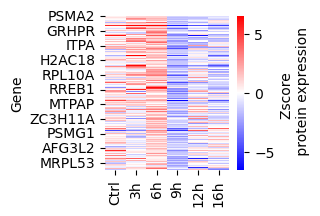

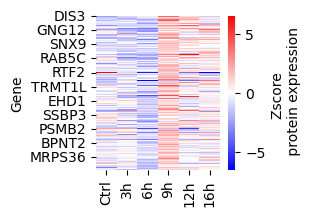

In [24]:
# See if the selection is good
for subgroup in groupDown_samples, groupUp_samples:
    plt.subplots(figsize=(2, 2))
    
    seaborn.heatmap(df_lateR[df_lateR.index.isin(subgroup)],
                    annot=False, cmap="bwr", 
                    linewidths=0, center=0, vmin=-6.5, vmax=6.5,
                    cbar_kws={'label': 'Zscore \n protein expression'})
    plt.show()

In [14]:
# # Save the list of significant linregress proteins for Overlapping
# numpy.savetxt(file_directory+"3) output/Proteomics/late_res_CoeffVar_proteins_DOWN.txt", 
#               groupDown_samples, delimiter="\t", fmt="% s")

# numpy.savetxt(file_directory+"3) output/Proteomics/late_res_CoeffVar_proteins_UP.txt", 
#               groupUp_samples, delimiter="\t", fmt="% s")

number of proteins:, 168


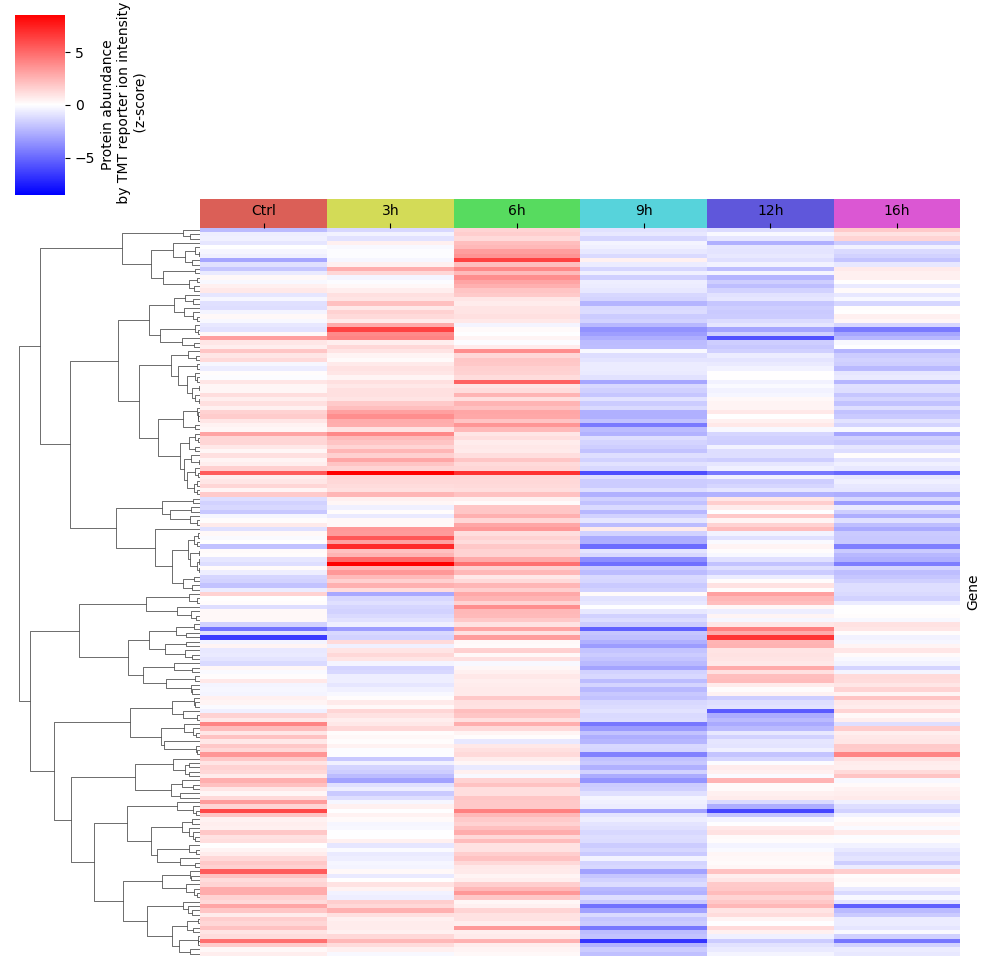

number of proteins:, 240


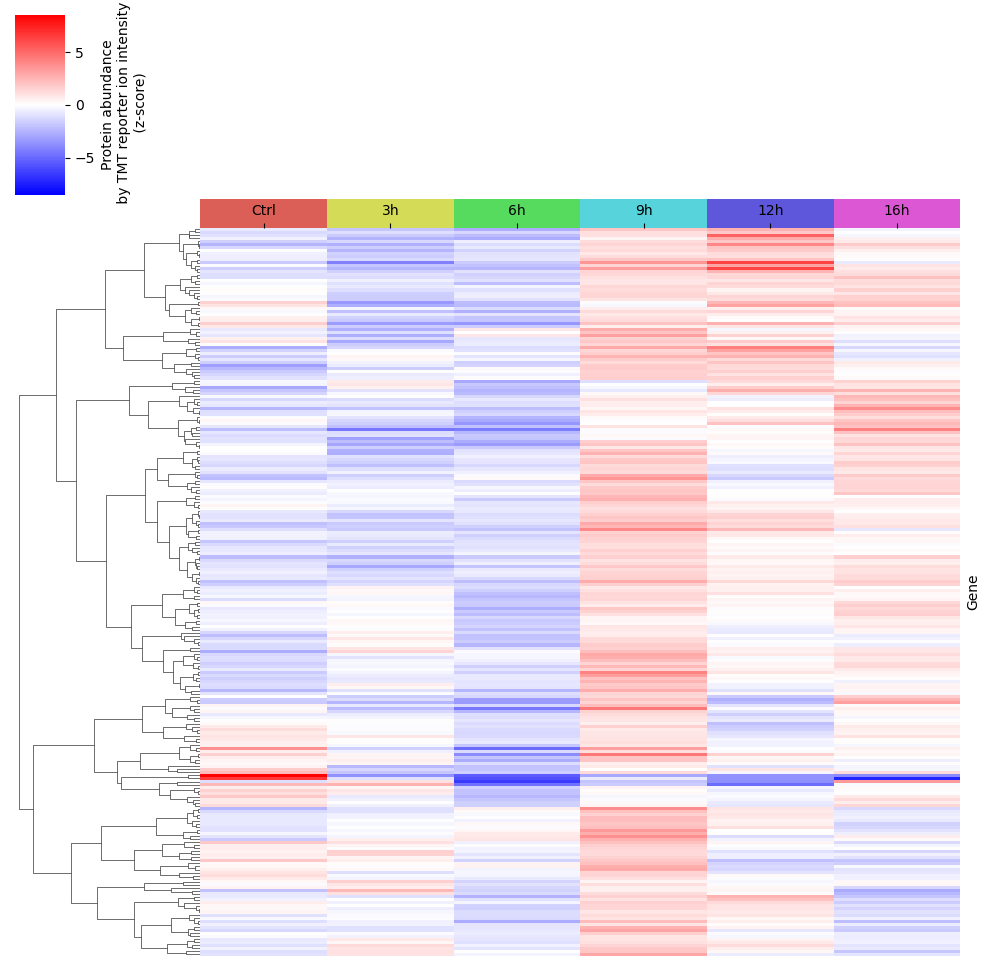

In [25]:
# Heatmap of proteins with high variation 3h from CTL
## define the colors, one color per condition 

lut = dict(zip(df_lateR.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_lateR.columns.map(lut)


## plot heatmap
for subgroup in groupDown_samples, groupUp_samples:  
    data = df_lateR[df_lateR.index.isin(subgroup)]
    print(f'number of proteins:, {len(data)}')
    
    g =  seaborn.clustermap(data, 
                            cmap='bwr', 
                            row_cluster=True, 
                            col_cluster=False, 
                            vmin=-8.5, vmax=8.5,
                            col_colors = col_colors_conditions,
                            cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                            xticklabels=True, yticklabels=False, 
                            method='complete', metric='cosine')

    g.ax_heatmap.xaxis.set_ticks_position('top')
    g.ax_heatmap.xaxis.set_label_position('top')
    plt.show()


number of proteins:, 168


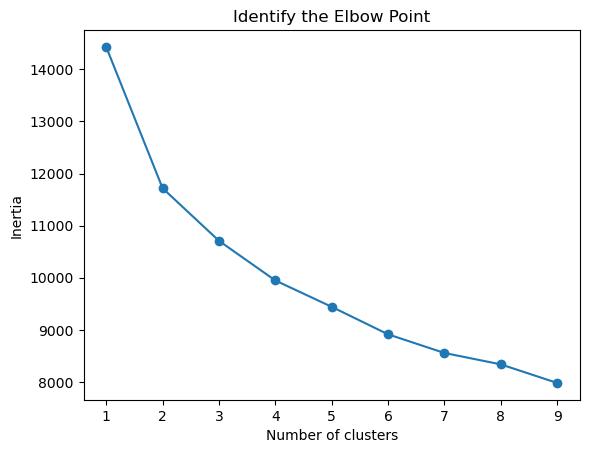

number of proteins:, 240


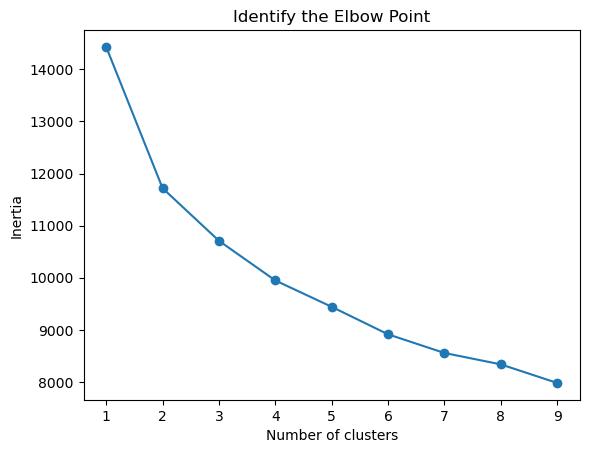

In [26]:
# Calculate Similarity/Distance
from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the elbow method
# "inertia" is the sum of squared distances of samples to their closest cluster center.

for subgroup in groupDown_samples, groupUp_samples:  
    data = df_lateR[df_lateR.index.isin(subgroup)]
    print(f'number of proteins:, {len(data)}')

    inertia = []
    for n_clusters in range(1, 10):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        kmeans.fit(df_zscore)
        inertia.append(kmeans.inertia_)

    plt.plot(range(1, 10), inertia, marker='o')
    plt.title('Identify the Elbow Point')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

### EnrichR

In [27]:
import warnings
# Filter out the specific warning
warnings.filterwarnings("ignore", message="The 'method' keyword in Series.replace is deprecated")
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy")

In [28]:
# names = gseapy.get_library_name(organism='Human')
# names

### Overtime Down regulated proteins

<Axes: title={'center': 'Transcription Factors results from\nOvTime - Down regulated proteins\n'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

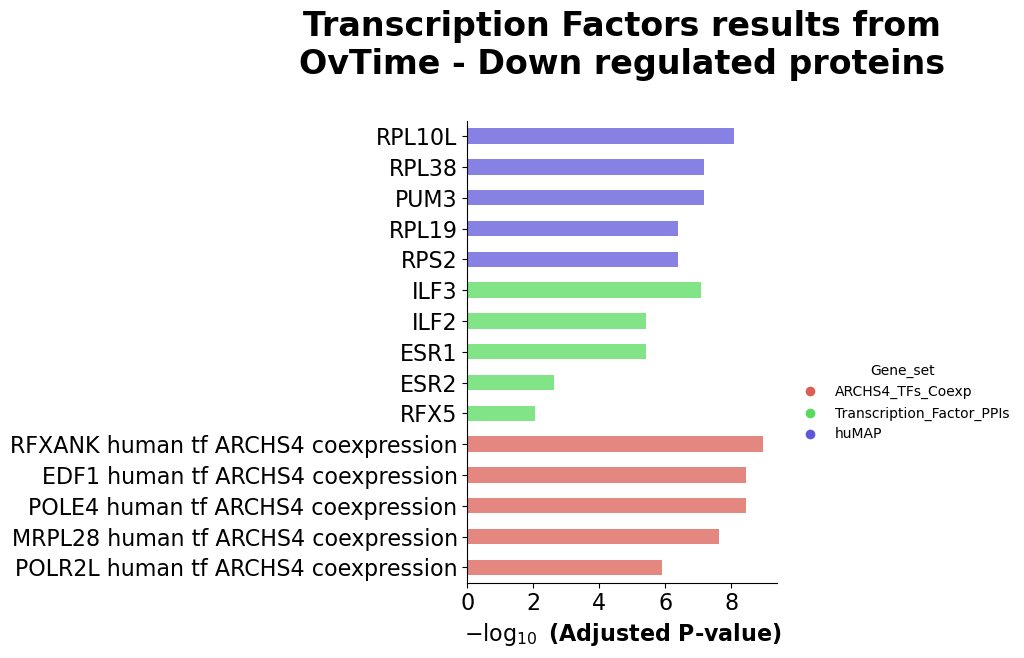

In [29]:
# Perform GO enrichment analysis using Enrichr
subgroup = groupDown_samples
sub_label ='OvTime - Down regulated'

enr_TF = gseapy.enrichr(gene_list = subgroup,
                        gene_sets= ['ARCHS4_TFs_Coexp',
                                    'Transcription_Factor_PPIs',
                                    'huMAP'],
                        organism='Human',
                        outdir='Enrichr_results',
                        cutoff=0.05)

# categorical scatterplot
colors = seaborn.hls_palette(3)
barplot(enr_TF.results,
        column="Adjusted P-value",
        group='Gene_set',
        size=10,
        top_term=5,
#         figsize=(3,5),
        title=f'Transcription Factors results from\n{sub_label} proteins\n',
        color=colors)

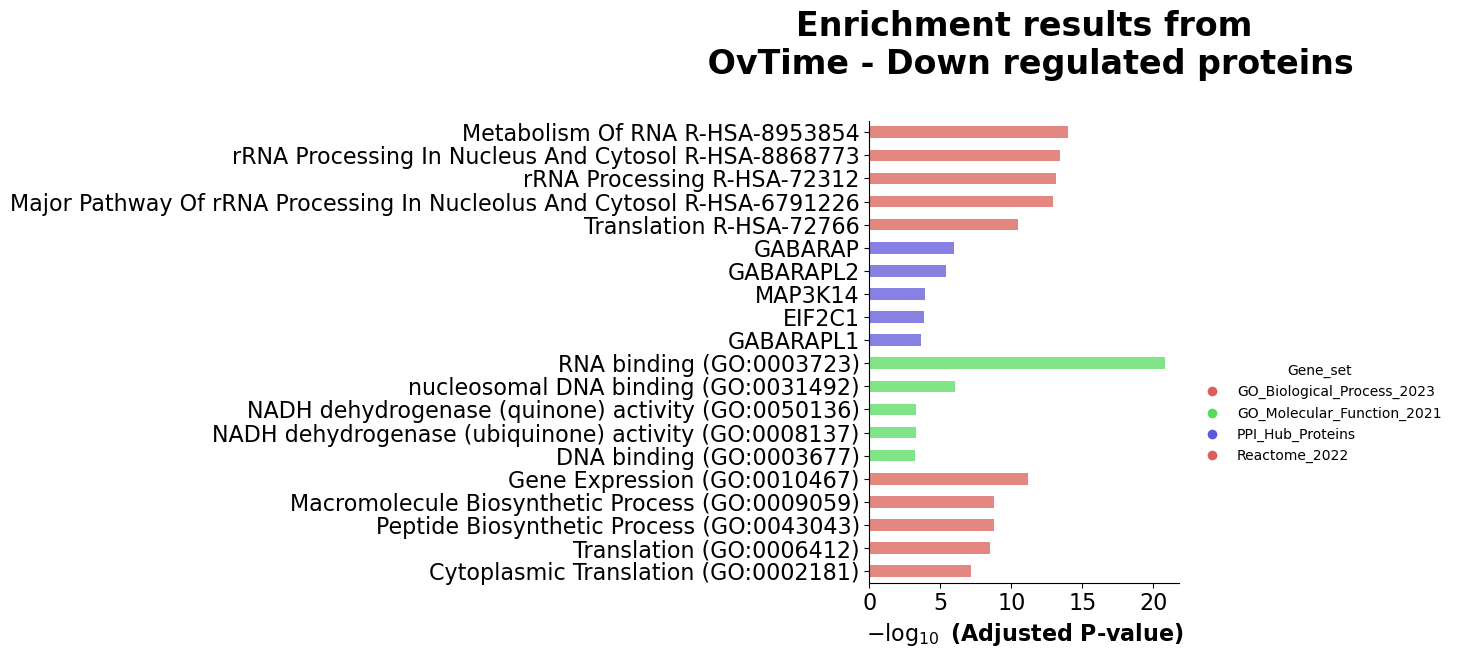

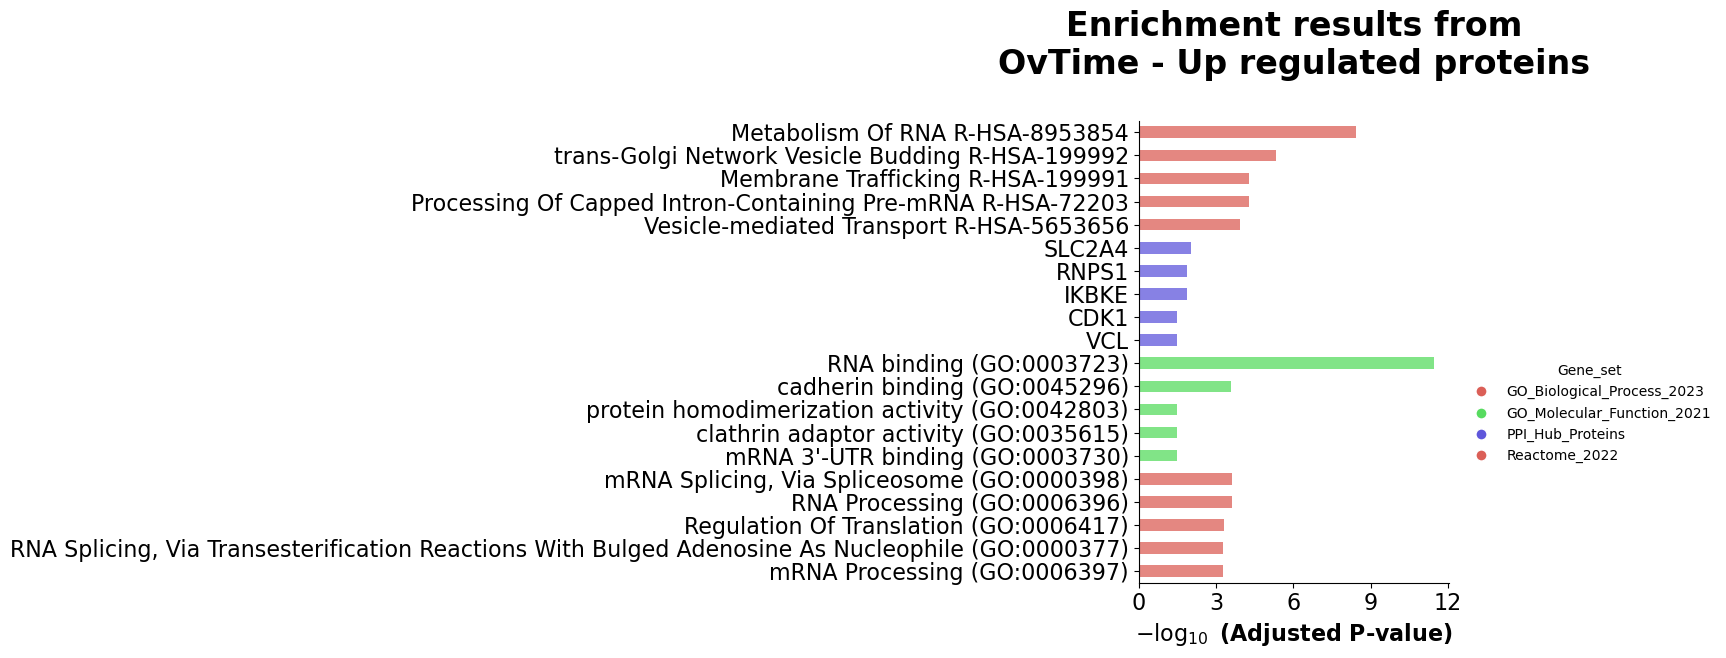

In [31]:
# Perform GO enrichment analysis using Enrichr
subgroups = groupDown_samples, groupUp_samples
sub_labels =' OvTime - Down regulated', 'OvTime - Up regulated'

for i in range(len(subgroups)):
    subgroup = subgroups[i]
    sub_label = sub_labels[i]
    
    enr = gseapy.enrichr(gene_list = subgroup,
                         gene_sets= ['GO_Molecular_Function_2021',
                                     'PPI_Hub_Proteins',
                                     'Reactome_2022',
                                     'GO_Biological_Process_2023'],
                         organism='Human',
                         outdir='Enrichr_results',
                         cutoff=1)

     # categorical scatterplot
    colors = seaborn.hls_palette(3)
    barplot(enr.results,
            column="Adjusted P-value",
            group='Gene_set', # set group, so you could do a multi-sample/library comparsion
    #         size=30,
            top_term=5,
            color=colors,
            title=f'Enrichment results from\n{sub_label} proteins\n',)